In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/func.ipynb
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/CMIP6_func.ipynb
%matplotlib inline

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35505")
client

<Client: 'tcp://127.0.0.1:35505' processes=5 threads=20, memory=78.51 GiB>

## Open CMIP6 online catalog & download desired data

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm_aero = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['od550aer'])
cam_aero = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['od550aer'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])

waccm_aero.df
cam_aero.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r2i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308


In [6]:
ds_dict_waccm_Aero = waccm_aero.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_dict_cam_aero = cam_aero.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
print(list(ds_dict_waccm_Aero.keys()))
print(list(ds_dict_cam_aero.keys()))
waccm_aod = ds_dict_waccm_Aero['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
cam_aod = ds_dict_cam_aero['CMIP.NCAR.CESM2.historical.AERmon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
['CMIP.NCAR.CESM2.historical.AERmon.gn']


In [ ]:
# Pinatubo eruption in 1991

In [11]:
# Select the starting year 5 years prior to the eruption
start_pina = cftime.DatetimeNoLeap(1986,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
waccm_1986_1996_aod = waccm_aod.sel(time=slice(start_pina, end_pina)).od550aer
# CAM
cam_1986_1996_aod = cam_aod.sel(time=slice(start_pina, end_pina)).od550aer

In [14]:
year_waccm_anom_1986_1996_aod = calc_yearly_anomaly(waccm_1986_1996_aod,1991)
year_cam_anom_1986_1996_aod = calc_yearly_anomaly(cam_1986_1996_aod,1991)

mon_waccm_anom_1986_1996_aod = calc_monthly_anomaly(waccm_1986_1996_aod,1991)
mon_cam_anom_1986_1996_aod = calc_monthly_anomaly(cam_1986_1996_aod,1991)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


## Calculate the weight for the northern and southern hemispheres

In [15]:
# Yearly
# WACCM
year_waccm_NH_anom_aod= computeWeightedMean(year_waccm_anom_1986_1996_aod.where(year_waccm_anom_1986_1996_aod['lat']>60.)).compute()
year_waccm_SH_anom_aod= computeWeightedMean(year_waccm_anom_1986_1996_aod.where(year_waccm_anom_1986_1996_aod['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_aod = computeWeightedMean(year_cam_anom_1986_1996_aod.where(year_cam_anom_1986_1996_aod['lat']>60.)).compute()
year_cam_SH_anom_aod = computeWeightedMean(year_cam_anom_1986_1996_aod.where(year_cam_anom_1986_1996_aod['lat']<-60.)).compute()

In [16]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
mon_waccm_NH_anom_aero= computeWeightedMean(mon_waccm_anom_1986_1996_aod.where(mon_waccm_anom_1986_1996_aod['lat']>60.)).compute()
mon_waccm_SH_anom_aero= computeWeightedMean(mon_waccm_anom_1986_1996_aod.where(mon_waccm_anom_1986_1996_aod['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_aod = computeWeightedMean(mon_cam_anom_1986_1996_aod.where(mon_cam_anom_1986_1996_aod['lat']>60.)).compute()
mon_cam_SH_anom_aod = computeWeightedMean(mon_cam_anom_1986_1996_aod.where(mon_cam_anom_1986_1996_aod['lat']<-60.)).compute()

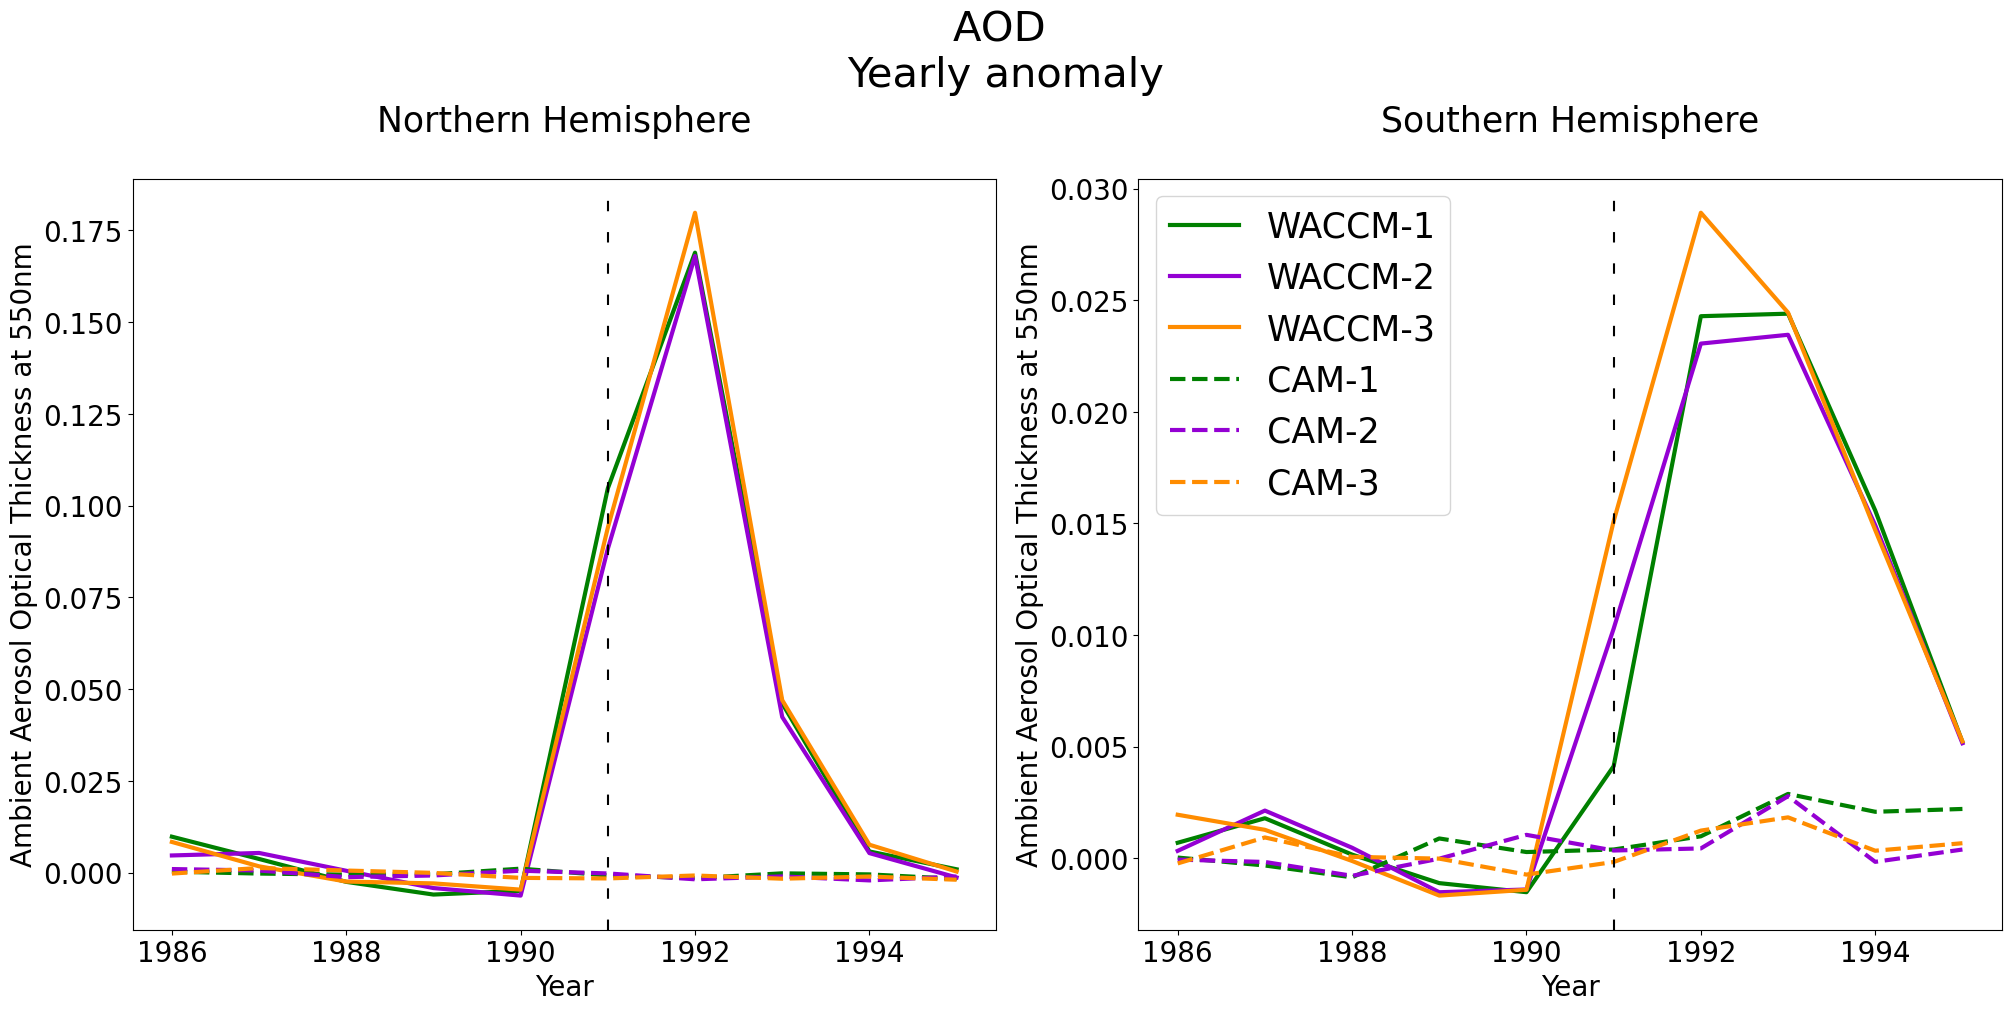

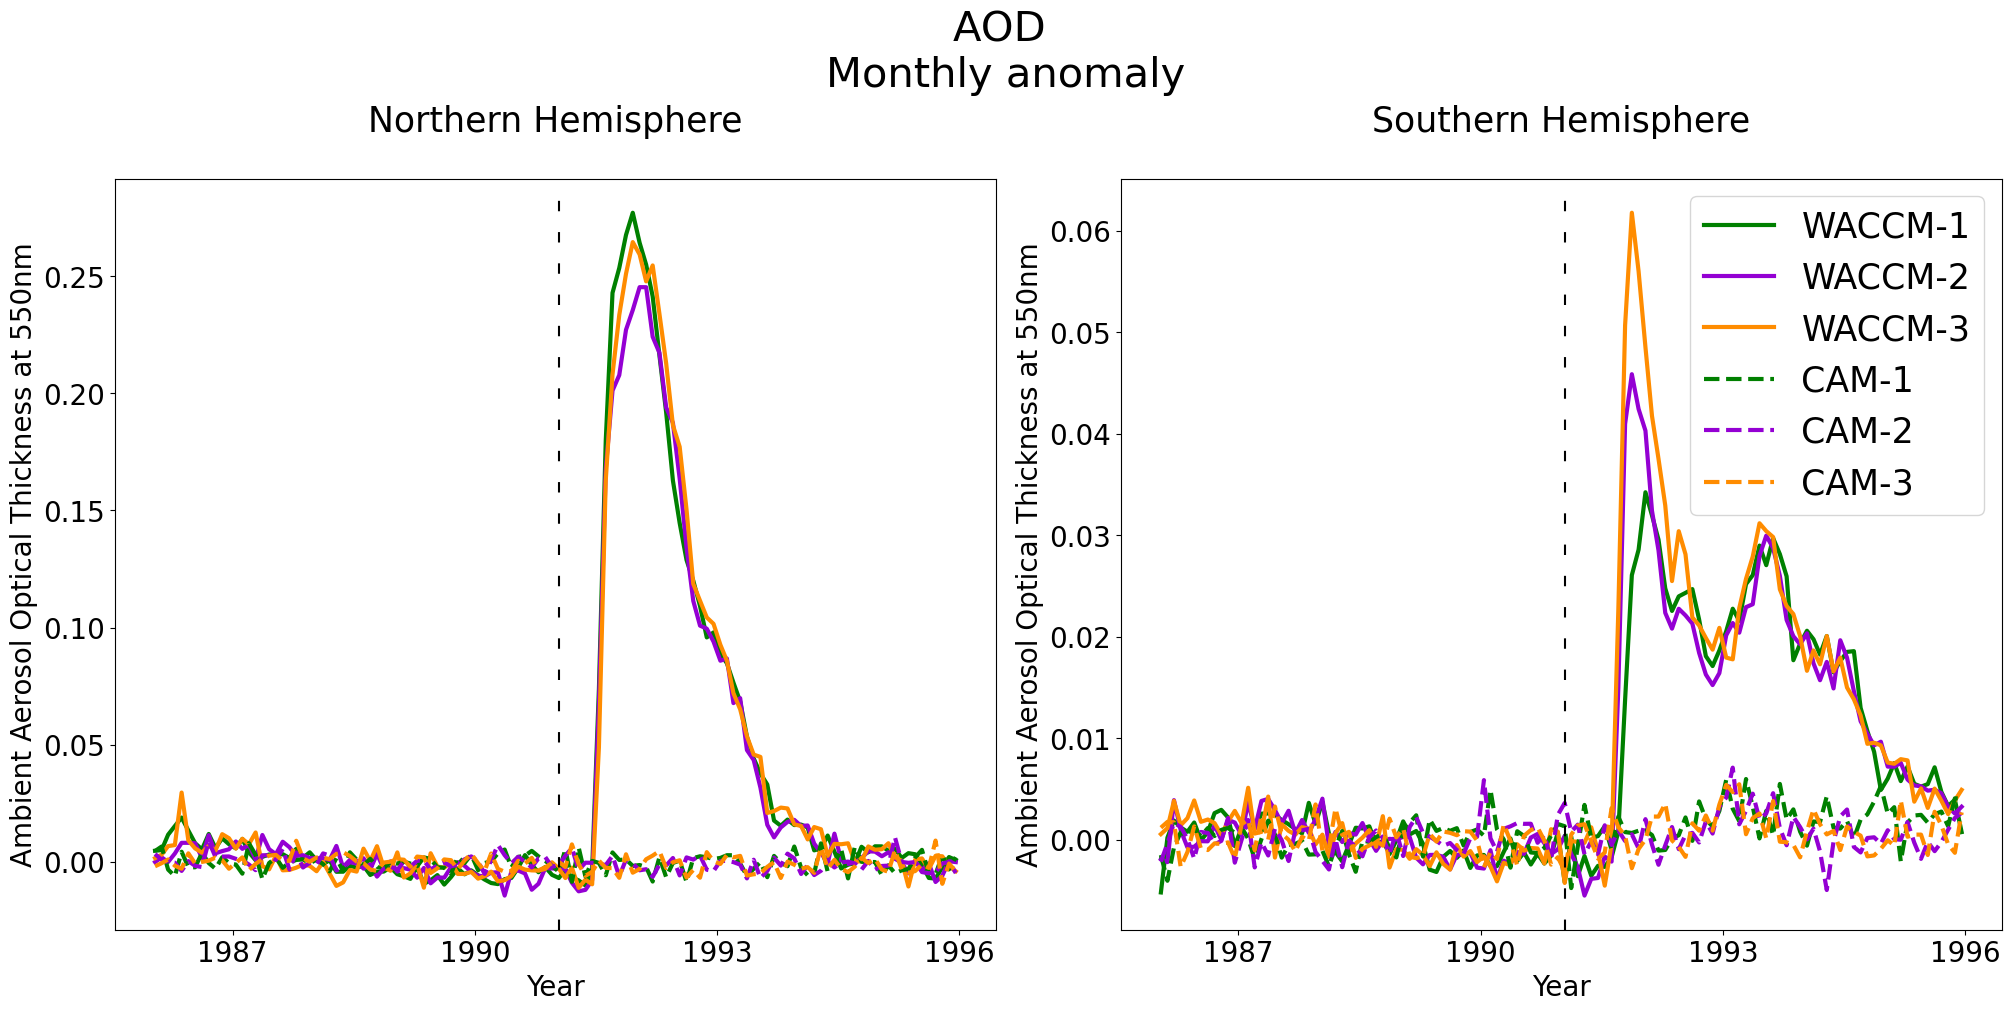

In [18]:
plot_year(year_waccm_NH_anom_aod,year_waccm_SH_anom_aod,year_cam_NH_anom_aod,year_cam_SH_anom_aod,'AOD \nYearly anomaly')
plot_month(mon_waccm_NH_anom_aero,mon_waccm_SH_anom_aero,mon_cam_NH_anom_aod,mon_cam_SH_anom_aod,'AOD \nMonthly anomaly')